# Exploring merge of pluto and sales data

Our goal in this notebook is to merge the pluto and sales data- to do so, we:
1. First, we try merging on just BBL.
2. Then we assess how this merge performed.
3. Given the performance of this merge, we explore other options to merge the two datasets.
    - Merge using the condo billing BBL
    - Merge using the low BBLs for a condo building
4. The final section includes unused code for parsing addresses, which may be useful at a later time.

## 1. Merging on just BBL

First, we naively try merging on just BBL- note we have to construct this feature for the sales data set:

In [270]:
import pandas as pd
import numpy as np

In [271]:
pluto = pd.read_csv('./../pluto/all_pluto.csv')

In [272]:
sales = pd.read_csv('./../sales/all_residential_2011_2015.csv')

In [273]:
bbl_features = ['BOROUGH','BLOCK','LOT']

for feature in bbl_features:
    sales[feature] = sales[feature].astype(str)

In [274]:
def make_bbl(row):
    bbl = row['BOROUGH'] + row['BLOCK'].zfill(5) + row['LOT'].zfill(4)
    return bbl

sales['BBL'] = sales.apply(make_bbl, axis=1).astype(float)

In [276]:
merged = pd.merge(sales, pluto, how='left', on=['BBL'])
merged.info()
num_sales = merged.shape[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369637 entries, 0 to 369636
Data columns (total 41 columns):
BOROUGH                           369637 non-null object
NEIGHBORHOOD                      369637 non-null object
BUILDING CLASS CATEGORY           369637 non-null object
TAX CLASS AT PRESENT              369637 non-null object
BLOCK                             369637 non-null object
LOT                               369637 non-null object
EASE-MENT                         369637 non-null object
BUILDING CLASS AT PRESENT         369637 non-null object
ADDRESS                           369637 non-null object
APARTMENT NUMBER                  369637 non-null object
ZIP CODE                          369637 non-null int64
RESIDENTIAL UNITS                 369637 non-null int64
COMMERCIAL UNITS                  369637 non-null int64
TOTAL UNITS                       369637 non-null int64
LAND SQUARE FEET                  369637 non-null int64
GROSS SQUARE FEET                 36963

## 2. Assessing naive merge performance.

First, it is apparent that this merge was not particularly successful, given the ~90000 records in the sales data that did not match a BBL in the Pluto dataset. To explain this, we consider the following information about lot numbers from the Pluto data dictionary:

<img src='tax_lot_DD.png' height=600 width=600>

Based on this description of the tax lots in the Pluto dataset, we suspect that the missing values correspond to condos- thus we proceed to check this possible explanation.

In [277]:
merged.loc[merged['Block'].isnull(),'BUILDING CLASS CATEGORY'].value_counts()

13  CONDOS - ELEVATOR APARTMENTS                63609
04  TAX CLASS 1 CONDOS                           6768
15  CONDOS - 2-10 UNIT RESIDENTIAL               5673
17  CONDO COOPS                                  4240
12  CONDOS - WALKUP APARTMENTS                   4153
17  CONDOPS                                      2368
16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT       453
05  TAX CLASS 1 VACANT LAND                       317
08  RENTALS - ELEVATOR APARTMENTS                 143
07  RENTALS - WALKUP APARTMENTS                   121
11A CONDO-RENTALS                                 113
02  TWO FAMILY HOMES                              109
01  ONE FAMILY HOMES                               72
02  TWO FAMILY DWELLINGS                           65
03  THREE FAMILY HOMES                             52
03  THREE FAMILY DWELLINGS                         38
01  ONE FAMILY DWELLINGS                           36
06  TAX CLASS 1 - OTHER                            33
14  RENTALS - 4-10 UNIT     

Thus, it is apparent the vast majority of these mismatched BBL's correspond to condos. We can confirm this another way, since the lot number is informative of the lot type (again from Pluto Data Dictionary):
<img src='meaning_of_lot_no.png' height=400 width=400>
We thus present a histogram of the lot numbers for mismatched sale records:

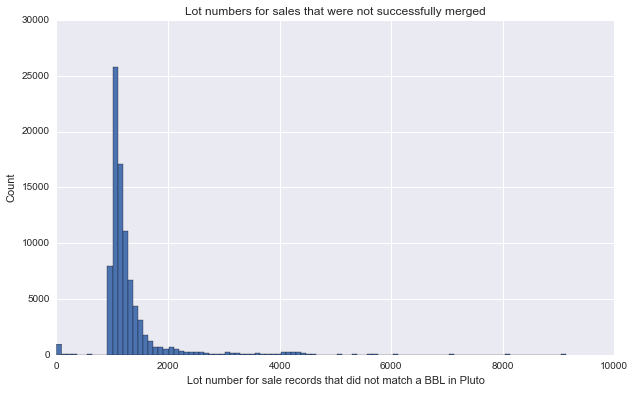

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,6))
plt.hist(merged.loc[merged['Borough'].isnull(),'LOT'].astype(int).values, bins=100)
plt.ylabel('Count')
plt.xlabel('Lot number for sale records that did not match a BBL in Pluto')
plt.title('Lot numbers for sales that were not successfully merged')
plt.show()

## 3. Attempting to correct the mismatch for condos

Thus, we now must try to correct this mismatch for condos. We will take a two-step approach, recalling there are two ways condo BBLs are represented in the PLUTO dataset:

1. Using the Condominium Billing BBL.
2. Using the lowest BBL number in the range of BBLs included in the condo;

We will try to correct for these BBL representations as follows:

1. First, we will  will be to use the BBL/Billing BBL map available from http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/pad16c.zip. Using this dataset, we can find all the BBLs corresponding to a condo, as well as the condo billing bbl. We can then
- Try to map the bbl given in the sales data to the condo billing bbl, and if that fails,
- Try to map the bbl given in the sales data to the lowest bbl in the range of bbls for the condo building.

In [279]:
PAD_cols = ['loboro', 'loblock','lolot', 'hiboro','hiblock','hilot','boro','block','lot','condoflag','billboro','billblock','billlot']
PAD = pd.read_csv('bobabbl.txt', index_col=None, usecols=PAD_cols)
PAD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880814 entries, 0 to 880813
Data columns (total 13 columns):
loboro       880814 non-null int64
loblock      880814 non-null int64
lolot        880814 non-null int64
hiboro       880814 non-null int64
hiblock      880814 non-null int64
hilot        880814 non-null int64
boro         880814 non-null int64
block        880814 non-null int64
lot          880814 non-null int64
billboro     880814 non-null object
billblock    880814 non-null object
billlot      880814 non-null object
condoflag    880814 non-null object
dtypes: int64(9), object(4)
memory usage: 87.4+ MB


In [280]:
PAD['condoflag'].value_counts()

     851475
C     29339
Name: condoflag, dtype: int64

In [281]:
PAD = PAD.loc[PAD['condoflag'] == 'C',:]

In [282]:
PAD = PAD.replace(r'\s+', np.nan, regex=True)

In [283]:
PAD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29339 entries, 14 to 877436
Data columns (total 13 columns):
loboro       29339 non-null int64
loblock      29339 non-null int64
lolot        29339 non-null int64
hiboro       29339 non-null int64
hiblock      29339 non-null int64
hilot        29339 non-null int64
boro         29339 non-null int64
block        29339 non-null int64
lot          29339 non-null int64
billboro     29243 non-null object
billblock    29243 non-null object
billlot      29243 non-null object
condoflag    29339 non-null object
dtypes: int64(9), object(4)
memory usage: 3.1+ MB


In [284]:
for col in PAD.columns:
    PAD[col] = PAD[col].astype(str)
    
del PAD['condoflag']

In [285]:
PAD.head()

,loboro,loblock,lolot,hiboro,hiblock,hilot,boro,block,lot,billboro,billblock,billlot
14,1,4,1001,1,4,1052,1,4,1001,1,00004,7501
15,1,4,7501,1,4,7501,1,4,7501,1,00004,7501
17,1,5,1001,1,5,1007,1,5,1001,1,00005,7501
18,1,5,7501,1,5,7501,1,5,7501,1,00005,7501
29,1,7,1001,1,7,1002,1,7,1001,1,00007,7501


In [286]:
def make_BBL_range(row):
    all_condo = []
    lo_BBL = row['loboro'] + row['loblock'].zfill(5) + row['lolot'].zfill(4)
    hi_BBL = row['hiboro'] + row['hiblock'].zfill(5) + row['hilot'].zfill(4)
    if row['billboro'] == 'nan':
        bill_BBL = np.nan
    else:
        bill_BBL = row['billboro'] + row['billblock'].zfill(5) + row['billlot'].zfill(4)
        bill_BBL = int(bill_BBL)
    for bbl in range(int(lo_BBL),int(hi_BBL) + 1):
        all_condo.append((bbl, int(lo_BBL), bill_BBL))
    return all_condo

In [287]:
all_condo_bbls = []
for row in PAD.iterrows():
    all_condo_bbls.extend(make_BBL_range(row[1]))

condo_map = pd.DataFrame.from_records(all_condo_bbls)

In [288]:
condo_map.columns = ['unit_BBL','lo_BBL','bill_BBL']
condo_map.head()

,unit_BBL,lo_BBL,bill_BBL
0,1000041001,1000041001,1.000048e+09
1,1000041002,1000041001,1.000048e+09
2,1000041003,1000041001,1.000048e+09
3,1000041004,1000041001,1.000048e+09
4,1000041005,1000041001,1.000048e+09


In [289]:
condo_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250201 entries, 0 to 250200
Data columns (total 3 columns):
unit_BBL    250201 non-null int64
lo_BBL      250201 non-null int64
bill_BBL    249884 non-null float64
dtypes: float64(1), int64(2)
memory usage: 5.7 MB


Now that we have a the PAD dataset, mapping individuals condo BBLs to the low BBL for that condo and the condo's billing BBL, we proceed using the ordering describing the PLUTO meta-data: specifically, we know that the condo billing BBL was used where available, and if not the low BBL was used.

In [290]:
unmatched = merged.loc[merged['Block'].isnull(),:].copy(deep=True)
unmatched = unmatched.dropna(axis=1)
unmatched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88489 entries, 1 to 369621
Data columns (total 22 columns):
BOROUGH                           88489 non-null object
NEIGHBORHOOD                      88489 non-null object
BUILDING CLASS CATEGORY           88489 non-null object
TAX CLASS AT PRESENT              88489 non-null object
BLOCK                             88489 non-null object
LOT                               88489 non-null object
EASE-MENT                         88489 non-null object
BUILDING CLASS AT PRESENT         88489 non-null object
ADDRESS                           88489 non-null object
APARTMENT NUMBER                  88489 non-null object
ZIP CODE                          88489 non-null int64
RESIDENTIAL UNITS                 88489 non-null int64
COMMERCIAL UNITS                  88489 non-null int64
TOTAL UNITS                       88489 non-null int64
LAND SQUARE FEET                  88489 non-null int64
GROSS SQUARE FEET                 88489 non-null int64


In [291]:
merge_on_billing_BBL = pd.merge(unmatched, condo_map, how='left', left_on=['BBL'], right_on=['unit_BBL'])
merge_on_billing_BBL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88489 entries, 0 to 88488
Data columns (total 25 columns):
BOROUGH                           88489 non-null object
NEIGHBORHOOD                      88489 non-null object
BUILDING CLASS CATEGORY           88489 non-null object
TAX CLASS AT PRESENT              88489 non-null object
BLOCK                             88489 non-null object
LOT                               88489 non-null object
EASE-MENT                         88489 non-null object
BUILDING CLASS AT PRESENT         88489 non-null object
ADDRESS                           88489 non-null object
APARTMENT NUMBER                  88489 non-null object
ZIP CODE                          88489 non-null int64
RESIDENTIAL UNITS                 88489 non-null int64
COMMERCIAL UNITS                  88489 non-null int64
TOTAL UNITS                       88489 non-null int64
LAND SQUARE FEET                  88489 non-null int64
GROSS SQUARE FEET                 88489 non-null int64
Y

In [292]:
merged_with_pluto = pd.merge(merge_on_billing_BBL, pluto, how='left', left_on=['bill_BBL'], right_on=['BBL'])
merged_with_pluto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88489 entries, 0 to 88488
Data columns (total 45 columns):
BOROUGH                           88489 non-null object
NEIGHBORHOOD                      88489 non-null object
BUILDING CLASS CATEGORY           88489 non-null object
TAX CLASS AT PRESENT              88489 non-null object
BLOCK                             88489 non-null object
LOT                               88489 non-null object
EASE-MENT                         88489 non-null object
BUILDING CLASS AT PRESENT         88489 non-null object
ADDRESS                           88489 non-null object
APARTMENT NUMBER                  88489 non-null object
ZIP CODE                          88489 non-null int64
RESIDENTIAL UNITS                 88489 non-null int64
COMMERCIAL UNITS                  88489 non-null int64
TOTAL UNITS                       88489 non-null int64
LAND SQUARE FEET                  88489 non-null int64
GROSS SQUARE FEET                 88489 non-null int64
Y

Now, since 'BBL_y' has the same number of non-missing values as 'bill_BBL', we know that the PAD billing BBL captures every recognized BBL in the sales data (i.e. no lo_BBL merge is needed). Finally, we update our merged 

In [293]:
merged_with_pluto.drop(['unit_BBL','lo_BBL','bill_BBL'], axis=1, inplace=True)
merged_with_pluto.rename(columns={'BBL_x': 'unit_BBL', 'BBL_y': 'Pluto_BBL'}, inplace=True)
merged_with_pluto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88489 entries, 0 to 88488
Data columns (total 42 columns):
BOROUGH                           88489 non-null object
NEIGHBORHOOD                      88489 non-null object
BUILDING CLASS CATEGORY           88489 non-null object
TAX CLASS AT PRESENT              88489 non-null object
BLOCK                             88489 non-null object
LOT                               88489 non-null object
EASE-MENT                         88489 non-null object
BUILDING CLASS AT PRESENT         88489 non-null object
ADDRESS                           88489 non-null object
APARTMENT NUMBER                  88489 non-null object
ZIP CODE                          88489 non-null int64
RESIDENTIAL UNITS                 88489 non-null int64
COMMERCIAL UNITS                  88489 non-null int64
TOTAL UNITS                       88489 non-null int64
LAND SQUARE FEET                  88489 non-null int64
GROSS SQUARE FEET                 88489 non-null int64
Y

In [294]:
merged['Pluto_BBL'] = merged['BBL']
merged.rename(columns={'BBL':'unit_BBL'}, inplace=True)

In [295]:
merged_with_pluto.set_index(merged.loc[merged['Block'].isnull(),:].index)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,ResArea,NumBldgs,NumFloors,AssessLand,AssessTot,YearBuilt,YearAlter1,YearAlter2,Pluto_BBL,CondoNo
1,4,AIRPORT LA GUARDIA,12 CONDOS - WALKUP APARTMENTS,2,949,1018,,R2,19-17 80TH STREET,2,...,25400.0,17.0,2.0,253499.0,942753.0,1939.0,0.0,0.0,4.009498e+09,100.0
139,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15904,1005,,R3,190 BEACH 62 STREET,43,...,20386.0,10.0,2.0,23700.0,291379.0,2010.0,0.0,0.0,4.159048e+09,626.0
140,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15904,1016,,R3,178 BEACH 62 STREET,48A,...,20386.0,10.0,2.0,23700.0,291379.0,2010.0,0.0,0.0,4.159048e+09,626.0
141,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15931,1006,,R3,128 BEACH 60 STREET,98A,...,19813.0,10.0,2.0,23593.0,290143.0,2010.0,0.0,0.0,4.159318e+09,626.0
142,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15931,1008,,R3,126 BEACH 60 STREET,99A,...,19813.0,10.0,2.0,23593.0,290143.0,2010.0,0.0,0.0,4.159318e+09,626.0
143,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15931,1014,,R3,133 BEACH 59 STREET,102A,...,19813.0,10.0,2.0,23593.0,290143.0,2010.0,0.0,0.0,4.159318e+09,626.0
144,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15931,1020,,R3,139 BEACH 60 STREET,105A,...,19813.0,10.0,2.0,23593.0,290143.0,2010.0,0.0,0.0,4.159318e+09,626.0
145,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15932,1001,,R3,104 BEACH 61 STREET,87,...,16599.0,9.0,2.0,21777.0,267800.0,2010.0,0.0,0.0,4.159328e+09,626.0
146,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15932,1002,,R3,104 BEACH 61 STREET,87,...,16599.0,9.0,2.0,21777.0,267800.0,2010.0,0.0,0.0,4.159328e+09,626.0
147,4,ARVERNE,04 TAX CLASS 1 CONDOS,1A,15932,1004,,R3,6018 BEACH FRONT ROAD,88A,...,16599.0,9.0,2.0,21777.0,267800.0,2010.0,0.0,0.0,4.159328e+09,626.0


In [296]:
merged = merged.loc[~merged['Block'].isnull(),:].append(merged_with_pluto)

In [307]:
print 'Successsful merge of %.2f percent of the sales data with Pluto' % ((1.0 -(num_sales - np.amin(merged.count().values))/ float(num_sales))*100)

Successsful merge of 99.39 percent of the sales data with Pluto


## Unused code (for parsing addresses)

In [ ]:
def address_to_list(address):
    return filter(None, str(address).strip().split(' '))

In [ ]:
def is_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

In [ ]:
def street_num_and_name(address):
    address_list = address_to_list(address)
    if len(address_list)==0:
        return np.nan
    else: #Some info in address field
        if is_int(address_list[0].split('-')[0]): #note need to split on '-' for queens addresses
            street_name = ' '.join(address_list[1:])
            street_name_list = street_name.split(',')
            if len(street_name_list) == 1:
                unit_nums = np.nan
            elif len(street_name_list) >= 2:
                street_name = street_name_list[0]
                unit_nums = street_name_list[1:]
            else:
                print address
                raise ValueError
            return address_list[0], street_name, unit_nums
        else:
            return np.nan, ' '.join(address_list), np.nan

In [ ]:
def split_df_address(df, colname):
    features = ['Street number','Street name', 'Unit number']
    if colname.isupper():
        features = [x.upper() for x in features]
    df[colname] = df[colname].apply(street_num_and_name)
    df[features] = df[colname].apply(pd.Series)